# Table of content

1. [Libraries Import](#section-one)

2. [Data import and selection](#section-two)

3. [Predicting Heatwaves](#section-three)
4. [Predicting Floods](#section-four)
5. [Hyperparameters tuning](#section-five)
6. [Conclusion and Submission](#section-six)


<a id="section-one"></a>
# Libraries import

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from numpy import concatenate
from math import sqrt

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout

%matplotlib inline

sns.set_theme()

# display up to 200 rows and 50 columns for dataframes
pd.options.display.max_rows = 200
pd.options.display.max_columns = 50

<a id="section-two"></a>
# Data import and selection

In [2]:
url = 'https://raw.githubusercontent.com/OmdenaAI/karachi-pakistan-weather-prediction/main/src/tasks/task_3_modelling/df_final_Karachi.csv'
data = pd.read_csv(url)
print(data.shape)
data.head()

(4966, 14)


,time,city,temperature_2m_min,temperature_2m_mean,temperature_2m_max,temp_range,daylight,precipitation_sum,precipitation_hours,precipitation_rate,windspeed_10m_max,windgusts_10m_max,shortwave_radiation_sum,et0_fao_evapotranspiration
0,2010-01-01,Karachi,14.8,20.9,26.0,11.2,10.633333,0.0,0,0.0,18.3,25.6,16.25,4.38
1,2010-01-02,Karachi,15.6,20.5,25.3,9.7,10.616667,0.0,0,0.0,24.6,35.3,9.15,3.84
2,2010-01-03,Karachi,14.3,19.9,25.0,10.7,10.633333,0.0,0,0.0,16.6,28.1,16.03,3.69
3,2010-01-04,Karachi,15.0,20.4,25.6,10.6,10.650000,0.0,0,0.0,14.0,22.7,16.32,3.63
4,2010-01-05,Karachi,16.3,20.7,25.4,9.1,10.650000,0.0,0,0.0,19.3,29.2,16.37,3.55


In [3]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
temperature_2m_min,4966.0,22.470963,5.083169,8.600000,18.400000,24.100,26.800000,32.500000
temperature_2m_mean,4966.0,26.247382,3.986358,14.300000,23.300000,27.600,29.275000,37.100000
temperature_2m_max,4966.0,30.567861,3.645286,17.700000,28.500000,31.100,33.100000,43.200000
temp_range,4966.0,8.096899,3.121997,1.000000,5.300000,8.100,10.700000,18.200000
daylight,4966.0,12.169536,1.068760,10.583333,11.133333,12.200,13.216667,13.683333
precipitation_sum,4966.0,0.499376,3.744586,0.000000,0.000000,0.000,0.000000,119.300000
precipitation_hours,4966.0,0.677004,2.711949,0.000000,0.000000,0.000,0.000000,24.000000
precipitation_rate,4966.0,0.050230,0.241179,0.000000,0.000000,0.000,0.000000,5.680952
windspeed_10m_max,4966.0,24.021023,6.423371,9.000000,19.300000,23.700,28.200000,47.900000
windgusts_10m_max,4966.0,37.990475,9.369277,14.000000,31.300000,37.800,44.300000,79.600000


In [4]:
# convert the df index to datetime
data['time'] = pd.to_datetime(data['time'], format='%Y/%m/%d')
df_k = data.drop(columns=['city'])
df_k = df_k.set_index('time')

# reorder the columns
col_names = df_k.columns.tolist()
col_names.insert(0, col_names.pop(2))
df_k = df_k[col_names]

df_k.head()

,temperature_2m_max,temperature_2m_min,temperature_2m_mean,temp_range,daylight,precipitation_sum,precipitation_hours,precipitation_rate,windspeed_10m_max,windgusts_10m_max,shortwave_radiation_sum,et0_fao_evapotranspiration
time,,,,,,,,,,,,
2010-01-01,26.0,14.8,20.9,11.2,10.633333,0.0,0,0.0,18.3,25.6,16.25,4.38
2010-01-02,25.3,15.6,20.5,9.7,10.616667,0.0,0,0.0,24.6,35.3,9.15,3.84
2010-01-03,25.0,14.3,19.9,10.7,10.633333,0.0,0,0.0,16.6,28.1,16.03,3.69
2010-01-04,25.6,15.0,20.4,10.6,10.650000,0.0,0,0.0,14.0,22.7,16.32,3.63
2010-01-05,25.4,16.3,20.7,9.1,10.650000,0.0,0,0.0,19.3,29.2,16.37,3.55


**Features**


* **temperature_2m_max, temperature_2m_min** -> Maximum and minimum daily air temperature at 2 meters above ground

* **temp_range** ->

* **precipitation_sum** -> Sum of daily precipitation

* **precipitation_hours** -> The number of hours with rain

* **precipitation_rate** ->

* **windspeed_10m_max, windgusts_10m_max** -> Maximum wind speed and gusts on a day

* **shortwave_radiation_sum** -> The sum of solar radiaion on a given day in cities

* **et0_fao_evapotranspiration** -> Daily sum of ET₀ Reference Evapotranspiration of a well watered grass field<br>
<br>

**Unit**

* **Temperature** -> °C (°F)

* **precipitation_sum** -> mm

* **rain_sum** -> mm

* **snowfall_sum** -> cm

* **precipitation_hours** -> hours

* **Windspeed** -> km/h

* **shortwave_radiation_sum** -> MJ/m²

* **et0_fao_evapotranspiration** -> mm

<a id="section-three"></a>
# Predicting Heatwaves

I differenciate the temperature max series as there is a yearly seasonality.
I create a naive function that will give a first indication of predictability.
It is not meant to be used for prediction but more for comparison with RNN and LSTM

## Naive Differenciating<br>
This is a one day prediction and i could/should be removed from the final model

In [5]:
def naive(data, feat, start, end, shift, start_pred, end_pred, graph=False):
  """
  that function is meant to calculate the naive differencing for a give dataframe (data), feature(feat) and a start and end date.
  It returns the mean absolute percentage error MAPE.
  """

  if graph == True:
        # plot the time series and its differenciated
        data[start:end][feat].plot(grid=True, marker=".", figsize=(20, 10))
        data[start:end].shift(shift)[feat].plot(grid=True, marker=".", figsize=(25, 10))

  # Calculate the Mean Absolute Percentate Error for a given perido
  diff = data[[feat]].diff(shift)[start_pred:end_pred]
  diff = diff.abs().mean()
  target = data[[feat]][start_pred:end_pred]
  MAPE = diff / target.abs().mean()*100
  plt.show()
  return MAPE

In [6]:
features = df_k.columns
for feat in features:
  MAPE = naive(df_k, feat, '2020-01', '2022-12', 365, '2022-12-15', '2022-12-31')
  print(f'The MAPE for {feat} is {MAPE}')

The MAPE for temperature_2m_max is temperature_2m_max    10.420014
dtype: float64
The MAPE for temperature_2m_min is temperature_2m_min    18.969555
dtype: float64
The MAPE for temperature_2m_mean is temperature_2m_mean    13.607226
dtype: float64
The MAPE for temp_range is temp_range    24.512535
dtype: float64
The MAPE for daylight is daylight    0.018498
dtype: float64
The MAPE for precipitation_sum is precipitation_sum    inf
dtype: float64
The MAPE for precipitation_hours is precipitation_hours    inf
dtype: float64
The MAPE for precipitation_rate is precipitation_rate    inf
dtype: float64
The MAPE for windspeed_10m_max is windspeed_10m_max    43.06115
dtype: float64
The MAPE for windgusts_10m_max is windgusts_10m_max    39.86764
dtype: float64
The MAPE for shortwave_radiation_sum is shortwave_radiation_sum    16.073574
dtype: float64
The MAPE for et0_fao_evapotranspiration is et0_fao_evapotranspiration    30.861692
dtype: float64


## LSTM

I use TensorFlow and Keras to predict univariate(1) target from multivariate features.

### a. Data Preparation
it includes:<br>
* creating a set for 'day-1' as the window size is 1
* include the target date for 'days_f'
* normalize the features (Cancelled in the latest version)

In [7]:
# convert series to supervised learning (adapted from https://machinelearningmastery.com/)
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
  n_vars = 1 if type(data) is list else data.shape[1]
  df = pd.DataFrame(data)
  cols, names = list(), list()
  #input sequence t-n, ..., t-1
  for i in range(n_in, 0, -1):
    cols.append(df.shift(i))
    names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
  # forecast sequence (t, t+1, t+2, t+3)
  for i in range(0, n_out):
    cols.append(df.shift(-i))
    if i == 0:
      names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
    else:
      names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
  # put it together
  agg = pd.concat(cols, axis=1)
  agg.columns = names
  # drop row with NaN values
  if dropnan:
    agg.dropna(inplace=True)
  return agg

In [8]:
# adapted from https://machinelearningmastery.com/

# number of days to forecast
days_f = 7

values = df_k.values
values = values.astype('float32')

# # normalize feature
# minmax = MinMaxScaler(feature_range=(0,1))
# values_minmaxed = minmax.fit_transform(values)
# frame as supervised learning

reframed = series_to_supervised(values, 1, days_f)
# I keep the temp max (t, t+1, etc) columns and drop all the others
reframed = reframed.iloc[:, list(range(12)) + [12*x for x in range(1,days_f+1)]]
# get the columns names right
df_k_columns = df_k.columns.tolist()
reframed.columns = df_k_columns + list(['temperature_2m_max (t' + str(x) +')' for x in range(0, days_f)])
reframed.head()

,temperature_2m_max,temperature_2m_min,temperature_2m_mean,temp_range,daylight,precipitation_sum,precipitation_hours,precipitation_rate,windspeed_10m_max,windgusts_10m_max,shortwave_radiation_sum,et0_fao_evapotranspiration,temperature_2m_max (t0),temperature_2m_max (t1),temperature_2m_max (t2),temperature_2m_max (t3),temperature_2m_max (t4),temperature_2m_max (t5),temperature_2m_max (t6)
1,26.000000,14.800000,20.900000,11.2,10.633333,0.0,0.0,0.0,18.299999,25.600000,16.250000,4.38,25.299999,25.0,25.6,25.4,24.1,26.000000,25.500000
2,25.299999,15.600000,20.500000,9.7,10.616667,0.0,0.0,0.0,24.600000,35.299999,9.150000,3.84,25.000000,25.6,25.4,24.1,26.0,25.500000,25.400000
3,25.000000,14.300000,19.900000,10.7,10.633333,0.0,0.0,0.0,16.600000,28.100000,16.030001,3.69,25.600000,25.4,24.1,26.0,25.5,25.400000,25.900000
4,25.600000,15.000000,20.400000,10.6,10.650000,0.0,0.0,0.0,14.000000,22.700001,16.320000,3.63,25.400000,24.1,26.0,25.5,25.4,25.900000,24.299999
5,25.400000,16.299999,20.700001,9.1,10.650000,0.0,0.0,0.0,19.299999,29.200001,16.370001,3.55,24.100000,26.0,25.5,25.4,25.9,24.299999,22.500000


### Define and Fit Model
the date range I used is from 2010-01-01 to 2022-12-31<br>
the 2023 values will be used for predictions

In [9]:
# adapted from https://machinelearningmastery.com/

# split into train and test sets
values = reframed.values
# we use 2010-2022 for training and testing purpose. 2023 will serve for evaluation
# train size is 80% and test size 20%
n_train_days = int(4748 * .80)

train = values[:n_train_days, :]
test = values[n_train_days:, :]
# split into input and outputs
train_X, train_y = train[:, 0:12], train[:, 12:(12+days_f)]
test_X, test_y = test[:, 0:12], test[:, 12:12+days_f]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

Epoch 1/60
60/60 - 7s - loss: 28.9741 - val_loss: 27.3992 - 7s/epoch - 122ms/step
Epoch 2/60
60/60 - 1s - loss: 25.3471 - val_loss: 23.6836 - 565ms/epoch - 9ms/step
Epoch 3/60
60/60 - 0s - loss: 21.6098 - val_loss: 20.0937 - 480ms/epoch - 8ms/step
Epoch 4/60
60/60 - 0s - loss: 18.2011 - val_loss: 16.7282 - 444ms/epoch - 7ms/step
Epoch 5/60
60/60 - 0s - loss: 14.8892 - val_loss: 13.5362 - 481ms/epoch - 8ms/step
Epoch 6/60
60/60 - 1s - loss: 11.7498 - val_loss: 10.3962 - 638ms/epoch - 11ms/step
Epoch 7/60
60/60 - 1s - loss: 8.6556 - val_loss: 7.5285 - 842ms/epoch - 14ms/step
Epoch 8/60
60/60 - 1s - loss: 6.0734 - val_loss: 5.3862 - 575ms/epoch - 10ms/step
Epoch 9/60
60/60 - 1s - loss: 4.3737 - val_loss: 4.0338 - 577ms/epoch - 10ms/step
Epoch 10/60
60/60 - 1s - loss: 3.4249 - val_loss: 3.2761 - 571ms/epoch - 10ms/step
Epoch 11/60
60/60 - 1s - loss: 2.9175 - val_loss: 2.7900 - 580ms/epoch - 10ms/step
Epoch 12/60
60/60 - 1s - loss: 2.4441 - val_loss: 2.2539 - 546ms/epoch - 9ms/step
Epoch 13

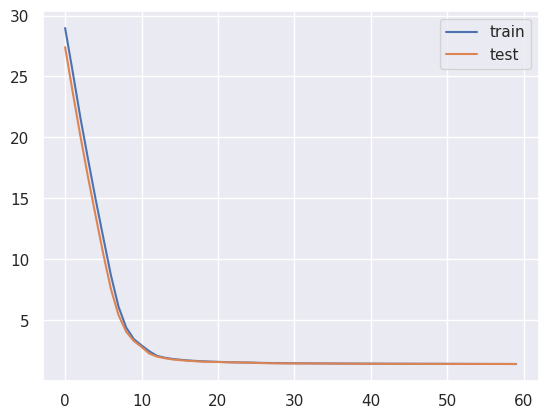

In [10]:
# adapted from https://machinelearningmastery.com/
# design network
model = Sequential()
model.add(LSTM(64, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(days_f))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=60, batch_size=64, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

### Evaluate Model

In [11]:
# make a prediction
yhat = model.predict(test_X)
yhat = pd.DataFrame(yhat)

ytrue = pd.DataFrame(test_y)

# calculate RMSE
mse_per_day = np.zeros(days_f)
mse_per_day_perc = list()
for i in range(days_f):
    mse_per_day[i] = mean_squared_error(ytrue.iloc[:, i], yhat.iloc[:, i])

target_min = ytrue.min()
target_max = ytrue.max()

# Scale the MSE values to a percentage
mse_percentage_per_day = (mse_per_day / (target_max - target_min)) * 100.0

# Print or use the MSE percentage values as needed
print("MSE Percentage per day:", mse_percentage_per_day)

37/37 [==============================] - 1s 3ms/step
MSE Percentage per day: 0    10.792617
1    13.696745
2    15.319153
3    16.762274
4    17.278890
5    17.907542
6    18.417757
dtype: float64


### Predictions on 2023

In [12]:
# adapted from https://machinelearningmastery.com/

# split into train and test sets
values = reframed.values
# we use a window from the 2023-01-01 to 2023-08-31
pred_size = len(values[4747:, :])
data_2023 = values[4747:, :]
sample_2023 = data_2023[:,:]
# split into input and outputs
sample_X, sample_y = sample_2023[:, 0:12], sample_2023[:, 12:(12+days_f)]

# reshape input to be 3D [samples, timesteps, features]
sample_X = sample_X.reshape((sample_X.shape[0], 1, sample_X.shape[1]))

In [13]:
yhat = model.predict(sample_X)
yhat = pd.DataFrame(yhat)

ytrue = pd.DataFrame(sample_y)

# calculate RMSE
mse_per_day = np.zeros(days_f)
mse_per_day_perc = list()
for i in range(days_f):
    mse_per_day[i] = mean_squared_error(ytrue.iloc[:, i], yhat.iloc[:, i])

target_min = ytrue.min()
target_max = ytrue.max()

# Scale the MSE values to a percentage
mse_percentage_per_day = (mse_per_day / (target_max - target_min)) * 100.0

# Print or use the MSE percentage values as needed
print("MSE Percentage per day:", mse_percentage_per_day)

7/7 [==============================] - 0s 3ms/step
MSE Percentage per day: 0    11.778536
1    13.016671
2    15.517497
3    16.218227
4    16.837490
5    17.545526
6    18.170161
dtype: float64


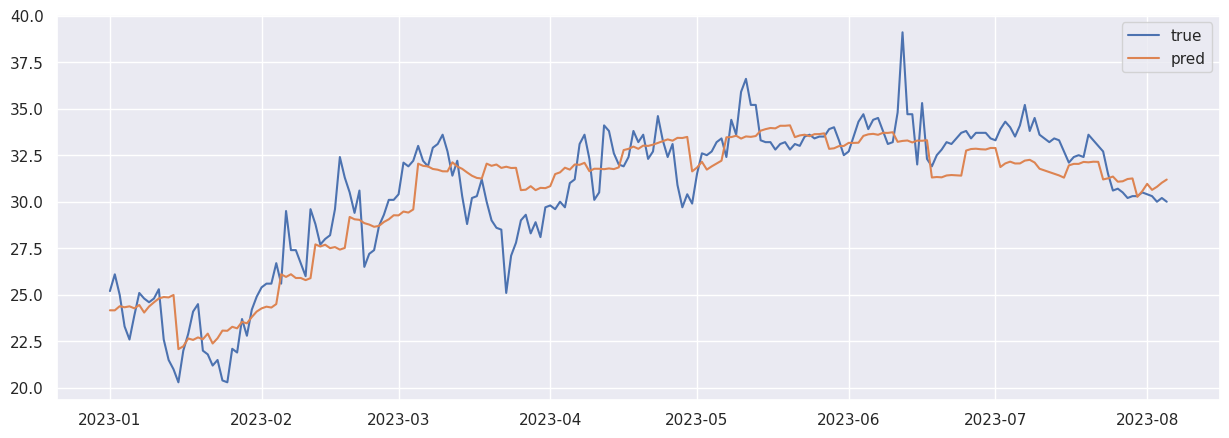

In [14]:
from datetime import datetime, timedelta
#adjust the dataframe to take one row out of days_f
ytrue = pd.DataFrame(ytrue)
ytrue = ytrue.iloc[::days_f].to_numpy().reshape(-1)

yhat = pd.DataFrame(yhat)
yhat = yhat.iloc[::days_f].to_numpy().reshape(-1)

# Define your start_date as a string
start_date_str = '2023-01-01'

# Convert the start_date string to a datetime object
start_date = datetime.strptime(start_date_str, '%Y-%m-%d')

# Add the specified number of days to the start_date
end_date = start_date + timedelta(days=(yhat.shape[0]-1))



# Create a boolean mask for the desired date range
mask = (df_k.index >= start_date) & (df_k.index <= end_date)

# Select the index labels within the date range
index_range = df_k.index[mask]

plt.figure(figsize=(15,5))
plt.plot(index_range,ytrue, label='true')
plt.plot(index_range,yhat, label='pred')
plt.legend()
plt.show()

<a id="section-four"></a>
# Predicting flood - NOT WORKING WITH MORE THAN ONE DAY PREDICTION

## LSTM

I use TensorFlow and Keras to predict univariate target from multivariate features.

In [15]:
# puting the column 'precipitation_rate' at index = 0
col_names = df_k.columns.tolist()
col_names.insert(0, col_names.pop(7))
df_k = df_k[col_names]

df_k.head()

,precipitation_rate,temperature_2m_max,temperature_2m_min,temperature_2m_mean,temp_range,daylight,precipitation_sum,precipitation_hours,windspeed_10m_max,windgusts_10m_max,shortwave_radiation_sum,et0_fao_evapotranspiration
time,,,,,,,,,,,,
2010-01-01,0.0,26.0,14.8,20.9,11.2,10.633333,0.0,0,18.3,25.6,16.25,4.38
2010-01-02,0.0,25.3,15.6,20.5,9.7,10.616667,0.0,0,24.6,35.3,9.15,3.84
2010-01-03,0.0,25.0,14.3,19.9,10.7,10.633333,0.0,0,16.6,28.1,16.03,3.69
2010-01-04,0.0,25.6,15.0,20.4,10.6,10.650000,0.0,0,14.0,22.7,16.32,3.63
2010-01-05,0.0,25.4,16.3,20.7,9.1,10.650000,0.0,0,19.3,29.2,16.37,3.55


In [16]:
display(df_k['precipitation_rate'].mean())
data['precipitation_rate'].mean()

0.050229820637970164

0.050229820637970164

In [17]:
# adapted from https://machinelearningmastery.com/

values = df_k.values
values = values.astype('float32')

# normalize feature
minmax = MinMaxScaler(feature_range=(0,1))
values_minmaxed = minmax.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(values_minmaxed, 1, 1)

# I keep the temp max (t) columns and drop all the others
reframed = reframed.iloc[:, list(range(13))]

# get the columns names right
df_k_columns = df_k.columns.tolist()
df_k_columns.append(df_k.columns[0])

reframed.columns = df_k_columns
reframed.columns.values[12] = 'precipitation_rate (t)'

In [18]:
# adapted from https://machinelearningmastery.com/

# split into train and test sets
values = reframed.values
# we use 2010-2022 for training and testing purpose. 2023 will serve for evaluation
# train size is 80% and test size 20%
n_train_days = int(4748 * .80)

train = values[:n_train_days, :]
test = values[n_train_days:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(3798, 1, 12) (3798,) (1167, 1, 12) (1167,)


Epoch 1/56
60/60 - 4s - loss: 0.0016 - accuracy: 0.9063 - val_loss: 0.0022 - val_accuracy: 0.8132 - 4s/epoch - 65ms/step
Epoch 2/56
60/60 - 0s - loss: 0.0016 - accuracy: 0.9063 - val_loss: 0.0021 - val_accuracy: 0.8132 - 270ms/epoch - 4ms/step
Epoch 3/56
60/60 - 0s - loss: 0.0015 - accuracy: 0.9063 - val_loss: 0.0019 - val_accuracy: 0.8132 - 279ms/epoch - 5ms/step
Epoch 4/56
60/60 - 0s - loss: 0.0015 - accuracy: 0.9063 - val_loss: 0.0018 - val_accuracy: 0.8132 - 339ms/epoch - 6ms/step
Epoch 5/56
60/60 - 0s - loss: 0.0014 - accuracy: 0.9063 - val_loss: 0.0018 - val_accuracy: 0.8132 - 308ms/epoch - 5ms/step
Epoch 6/56
60/60 - 0s - loss: 0.0014 - accuracy: 0.9063 - val_loss: 0.0017 - val_accuracy: 0.8132 - 267ms/epoch - 4ms/step
Epoch 7/56
60/60 - 0s - loss: 0.0013 - accuracy: 0.9063 - val_loss: 0.0017 - val_accuracy: 0.8132 - 268ms/epoch - 4ms/step
Epoch 8/56
60/60 - 0s - loss: 0.0013 - accuracy: 0.9063 - val_loss: 0.0017 - val_accuracy: 0.8132 - 298ms/epoch - 5ms/step
Epoch 9/56
60/60 -

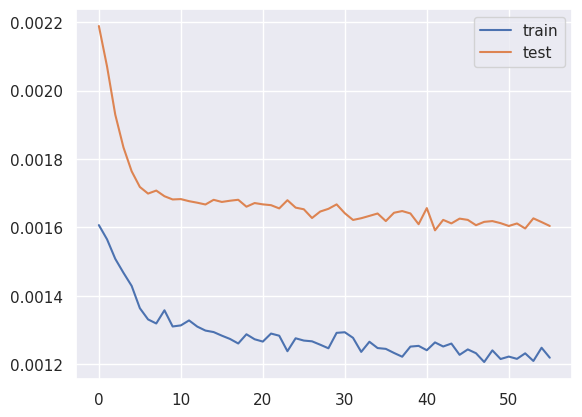

In [19]:
# adapted from https://machinelearningmastery.com/
# design network
model = Sequential()
model.add(LSTM(16, return_sequences=True, activation='relu', input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.1))
model.add(LSTM(16, activation='relu'))
model.add(Dense(1))
model.compile(loss='mse', optimizer='Adam', metrics=['accuracy'])
# fit network
history = model.fit(train_X, train_y, epochs=56, batch_size=64, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [20]:
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 1, 16)             1856      
                                                                 
 dropout (Dropout)           (None, 1, 16)             0         
                                                                 
 lstm_2 (LSTM)               (None, 16)                2112      
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 3,985
Trainable params: 3,985
Non-trainable params: 0
_________________________________________________________________
None


In [21]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

# invert scaling for forecast
inv_pred = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_pred = minmax.inverse_transform(inv_pred)
inv_yhat = inv_pred[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_test = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = minmax.inverse_transform(inv_test)
inv_y = inv_test[:,0]
# # calculate RMSE
rmse = sqrt(mean_squared_error(test_y, yhat))

print('Test RMSE: %.3f' % rmse)
print(test_y.mean())
print('rmse %', rmse/test_y.mean()*100)


37/37 [==============================] - 1s 3ms/step
Test RMSE: 0.040
0.01301982
rmse % 307.6403987484471


### Prediction

In [22]:
# adapted from https://machinelearningmastery.com/

# split into train and test sets
values = reframed.values
# we use a window from from 2023-01-01 to 2023-08-31
pred_size = len(values[4747:, :])
data_2023 = values[4747:, :]
sample_2023 = data_2023[:,:]

# split into input and outputs
sample_X, sample_y = sample_2023[:, :-1], sample_2023[:, -1]

# reshape input to be 3D [samples, timesteps, features]
sample_X = sample_X.reshape((sample_X.shape[0], 1, sample_X.shape[1]))


In [23]:
# make a prediction
yhat = model.predict(sample_X)

# invert scaling for forecast
sample_X = sample_X.reshape(sample_X.shape[0],sample_X.shape[2])
inv_yhat = concatenate((yhat, sample_X[:, 1:]), axis=1)

inv_yhat = minmax.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# invert scaling for actual
y = sample_y.reshape((len(sample_y), 1))

inv_y = concatenate((y, sample_X[:, 1:]), axis=1)
inv_y = minmax.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)
print(inv_y.mean())
print('rmse %', rmse/inv_y.mean()*100)

7/7 [==============================] - 0s 3ms/step
Test RMSE: 0.167
0.04635838
rmse % 360.4750030644777


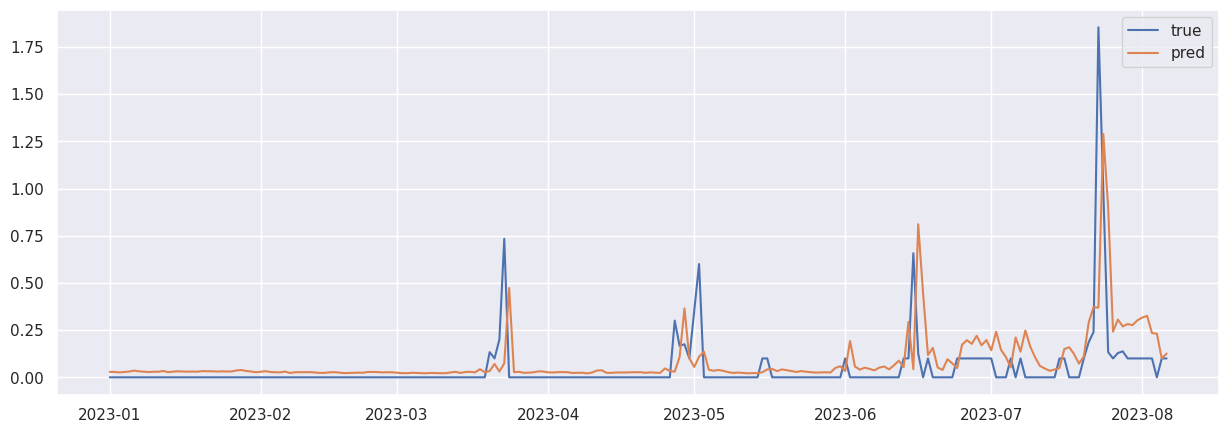

In [24]:
start_date = '2023-01-01'
end_date = '2023-08-06'

# Create a boolean mask for the desired date range
mask = (df_k.index >= start_date) & (df_k.index <= end_date)

# Select the index labels within the date range
index_range = df_k.index[mask]

plt.figure(figsize=(15,5))
plt.plot(index_range,inv_y, label='true')
plt.plot(index_range,inv_yhat, label='pred')
plt.legend()
plt.show()

The result is surprising because we could conclude that the model can predict very high precipitation rate but the peak are much higher that the in reality. Also I think prediction on `precipitation rate` should not include `precipitation_sum`	or `precipitation_hours`. I'll make test in that sense.